<a href="https://colab.research.google.com/github/Tom-Cast/mvp_puc_rio_analise/blob/main/MVP_analise_de_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise comparativa de rendimento entre colégios mistos e de gênero exclusivo

## Definição de Problema


A realidade de alguns países ainda carrega uma divisão entre modelos de escola: mistos ou exclusivos em relação ao gênero. Historiadores da educação já debateram anteriormente sobre o papel social e situação econômica dos colégios "só para garotas" no Brasil, mas como se sustentaria uma tese de que esses colégios tenderiam a gerar alunos mais produtivos - tendo por "produtividade" o aproveitamento desses alunos em exames padronizados?

A presente análise inicia uma investigação no tema, tomando por base um dataset estrangeiro com dados do aproveitamento de alunos e alunas em exames padronizados, bem como informações das escolas. O objetivo final é responder a questão:

- Há diferença significativa a se esperar nas notas de alunos e/ou alunas a frequentarem colégios exclusivos de gênero e não mistos?

## Detalhamento das bases


A base de dados fornecida foi extraída do curso de modelagem de Harvard1 e está organizada em
quatro arquivos diferentes:

- "cat_school" - Variáveis categóricas que são aplicadas às escolas.
- "num_school" - Variáveis numéricas que são aplicadas às escolas.
- "cat_student" - Variáveis categóricas que são aplicadas aos estudantes.
- "num_student" - Variáveis numéricas que são aplicadas aos estudantes.

Os dados das diferentes bases são descritos abaixo. As tabelas de estudante e escola são cruzadas
através do campo school, os ids dos estudantes (student) são únicos para cada escola.

"school" = identificador da escola
"normexam" = nota de exame normalizada
"schgend" = gênero da escola
"schavg" = média de nota pela escola
"vr" = nível de razão verbal do estudante
"intake" = faixa da nota do estudante
"standLRT" = nota em exam LR padrão
"sex" = gênero do estudante
"type" = Tipo da escola (mista ou exclusiva)
"student" = identificador único de estudante para cada escola

# Pré-processamento de dados

## Bibliotecas utilizadas

In [83]:
# Imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split ### Para divisão do dataset em treino e teste
from scipy.stats import ttest_ind # Para testagem de hipóteses


## Carregamento de dados

In [51]:
# Data set Cat_school

url_cat_school = "https://raw.githubusercontent.com/Tom-Cast/mvp_puc_rio_analise/main/cat_school_data.csv"

cat_school = pd.read_csv(url_cat_school, sep= ";", header = 0)

# Dataset cat_student

url_cat_student = "https://raw.githubusercontent.com/Tom-Cast/mvp_puc_rio_analise/main/cat_student_data.csv"

cat_student = pd.read_csv(url_cat_student, sep = ";", header = 0)

# Dataset num_school

url_num_school = "https://raw.githubusercontent.com/Tom-Cast/mvp_puc_rio_analise/main/num_school_data.csv"

num_school = pd.read_csv(url_num_school, sep = ";", header = 0)

# Dataset num_student

url_num_student = "https://raw.githubusercontent.com/Tom-Cast/mvp_puc_rio_analise/main/num_student_data.csv"

num_student = pd.read_csv(url_num_student, sep = ";", header = 0)

## Limpeza de dados

#### Obs.: Os datasets somente fazem sentido para o projeto uma vez relacionados, no entanto cada arquivo apresenta desafior específicos para seu pré-processamento, exigindo etapas específicas antes de serem unidos em um dataset válido

### Processamendo do arquivo cat_school



In [52]:
# Passando para formato wide
cat_school_wide = cat_school.pivot(index='school', columns='variable',
                                   values='value')

# Verificando NAs e duplicados
print(cat_school_wide.isna().any().any())
print(cat_school_wide.duplicated().any())

# Verificando por erros nas variáveis
print(cat_school_wide['schgend'].unique())
print(cat_school_wide['type'].unique())

# Checando estrutura
print(cat_school_wide.info())

# Salvando versão final
cat_school_final = cat_school_wide.copy()



False
True
['mixed' 'girls' 'boys']
['Mxd' 'Sngl']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 1 to 65
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   schgend  65 non-null     object
 1   type     65 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB
None


### Processamento arquivo cat_student

In [53]:
# Verificando NAs e duplicados
print(cat_student.isna().any().any())
print(cat_student.duplicated().any())

# Conferindo duplicadas
duplicadas = cat_student[cat_student.duplicated()]
print(duplicadas)

# Retirando duplicados
cat_student_clean = cat_student.drop_duplicates()

# Identificando e removendo novos duplicados
merged_duplicates = (
    cat_student_clean.groupby(['school', 'student', 'variable'])
    .filter(lambda group: len(group) > 1)
)
merged_duplicates = merged_duplicates.drop_duplicates(
    ['school', 'student', 'variable'])

print(merged_duplicates)

cat_student_final_clean = pd.merge(
    cat_student_clean.groupby(['school', 'student', 'variable'])
    .size().reset_index(name='n'),
    cat_student_clean,
    on=['school', 'student', 'variable']
)
cat_student_final_clean = cat_student_final_clean[
    cat_student_final_clean['n'] == 1].drop('n', axis=1)

# Verificando por erros nas variáveis
print(cat_student_final_clean['school'].unique())
print(cat_student_final_clean['variable'].unique())

# Passando para formato wide
cat_student_wide = cat_student_final_clean.pivot(index=['school', 'student'],
                                                 columns='variable',
                                                 values='value').reset_index()

# Checando novamente por NAs
print(cat_student_wide.isna().any().any())

# Eliminando novos NAs
cat_student_wide_clean = cat_student_wide.dropna()

# Checando estrutura
print(cat_student_wide_clean.info())

# Salvando arquivo final
cat_student_final = cat_student_wide_clean.copy()



False
True
       school  student variable       value
3228       50       39   intake     mid 50%
3316       52        2   intake  bottom 25%
3351       52       21   intake     top 25%
7287       50       39      sex           F
7375       52        2      sex           M
7410       52       21      sex           M
10877      43       86       vr     top 25%
11346      50       39       vr     mid 50%
11434      52        2       vr     mid 50%
11469      52       21       vr     mid 50%
      school  student variable    value
2758      43       86   intake  mid 50%
6817      43       86      sex        M
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]
['intake' 'sex' 'vr']
True
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3798 entries, 0 to 4009
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --

### Processamento arquivo num_school

In [68]:
# Verificando NAs e duplicados
print(num_school.isna().any().any())
print(num_school.duplicated().any())

# Verificando estrutura
print(num_school.info())

# Substituindo vírgulas por pontos na coluna 'value'
num_school['value'] = num_school['value'].str.replace(',', '.')

# Removendo a coluna 'variable' e renomeando 'value' para 'schavg'
num_school_final = num_school.drop(columns=['variable']).rename(columns={'value': 'schavg'})

# Convertendo a coluna 'schavg' para o formato numérico
num_school_final['schavg'] = pd.to_numeric(num_school_final['schavg'])

# Exibindo as primeiras linhas do DataFrame após as modificações
print(num_school_final.head())


False
False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   school    65 non-null     int64 
 1   variable  65 non-null     object
 2   value     65 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
   school    schavg
0       1  0.166175
1       2  0.395149
2       3  0.514155
3       4  0.091764
4       5  0.210525


### Processamento arquivo num_student

In [29]:
# Removendo NAs e duplicatas
num_student_clean = (
    num_student
    .dropna()
    .drop_duplicates()
)

# Verificando por erros nas variáveis antes da limpeza
print(num_student['variable'].unique())
print(num_student['school'].unique())
print(num_student['school'].nunique())

# Removendo duplicatas de 'school' e 'student'
num_student_clean2 = num_student_clean.drop_duplicates(subset=['school', 'student'])

# Passando para formato wide
num_student_wide = num_student_clean.pivot_table(
    index=['school', 'student'],
    columns='variable',
    values='value',
    aggfunc='first'
).reset_index()

# Checagem e tratamento final por NAs
print(num_student_wide.isna().any())

num_student_wide_clean = num_student_wide.dropna()

# Corrigindo Estrutura
num_student_corrected = num_student_wide_clean.assign(
    normexam=pd.to_numeric(num_student_wide_clean['normexam'].str.replace(',', '.')),
    standLRT=pd.to_numeric(num_student_wide_clean['standLRT'].str.replace(',', '.'))
)

# Salvando arquivo final
num_student_final = num_student_corrected.copy()

['normexam' 'standLRT']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]
65
variable
school      False
student     False
normexam     True
standLRT     True
dtype: bool
variable  school  student  normexam  standLRT
0              1      1.0  1.506185  0.784362
1              1      4.0 -0.555112 -1.033970
2              1      6.0 -1.335315 -0.951318
3              1      7.0 -0.555112 -2.356393
4              1     13.0 -0.197611 -0.290107
...          ...      ...       ...       ...
4004          65    147.0  1.109438  1.032317
4005          65    148.0 -0.623051  0.288453
4006          65    152.0  0.134067 -0.207455
4008          65    154.0  0.478194 -0.124804
4009          65    155.0 -0.129085 -0.372758

[3911 rows x 4 columns]
      school  student  variable      value
1          1    143.0  normexam  0,2613242
2          1    14

### Formação de dataset unificado

Para seguir análise, faz-se necessário a formação de um dataset único para rodar as estatísticas necessárias e visualizações.

In [69]:
# Left join cat_school_final e cat_student_final
cat_data = pd.merge(cat_school_final, cat_student_final, on='school', how='left')

# Left join num_school_final e num_student_final
num_data = pd.merge(num_school_final, num_student_final, on='school', how='left')

# Ajustando tipos de dados
##cat_data['school'] = pd.Categorical(cat_data['school'])

num_data['student'] = num_data['student'].astype(int)
num_data['school'] = pd.Categorical(num_data['school'])
num_data['normexam'] = pd.to_numeric(num_data['normexam'])
num_data['standLRT'] = pd.to_numeric(num_data['standLRT'])

# Left join cat_data e num_data
final_data = pd.merge(cat_data, num_data, on=['school', 'student'], how='left')

# Checando por Nas
print(final_data.isna().any().any())
print(final_data.isna().sum())

# Visualizando conjunto com NAs
print(final_data[final_data.isna().any(axis=1)])

# Eliminação de conjunto com NAs
final_data = final_data.dropna()

True
school       0
schgend      0
type         0
student      0
intake       0
sex          0
vr           0
schavg      92
normexam    92
standLRT    92
dtype: int64
     school schgend  type  student      intake sex       vr  schavg  normexam  \
25        1   mixed   Mxd       84  bottom 25%   F  mid 50%     NaN       NaN   
67        1   mixed   Mxd      220     top 25%   M  mid 50%     NaN       NaN   
131       3   mixed   Mxd       64     mid 50%   M  top 25%     NaN       NaN   
269       5   mixed   Mxd      166     mid 50%   M  top 25%     NaN       NaN   
364       7   girls  Sngl       16     mid 50%   F  mid 50%     NaN       NaN   
...     ...     ...   ...      ...         ...  ..      ...     ...       ...   
3747     65   girls  Sngl       59     mid 50%   F  mid 50%     NaN       NaN   
3754     65   girls  Sngl       71     top 25%   F  mid 50%     NaN       NaN   
3774     65   girls  Sngl      112     mid 50%   F  mid 50%     NaN       NaN   
3790     65   girls  S

# Análise exploratória

<ipython-input-77-28f09a4683af>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = final_data.corr()


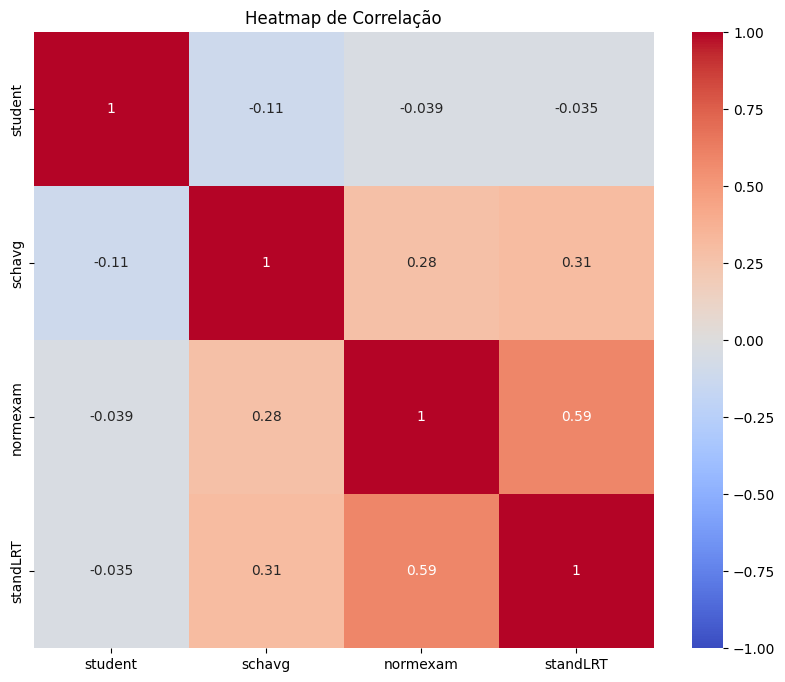

In [77]:
# Matriz de correlações
corr_matrix = final_data.corr()

# Ajustando a escala do heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Heatmap de Correlação')
plt.show()

Normalizado, o heatmap acima enfatiza a ausência de correlações negativas relevantes e a presença da prova "standLRT" como forte indicador da nota em "normexam". Sendo a relação entre os exames e a média das escolas também relevante, mas significamente menos forte.

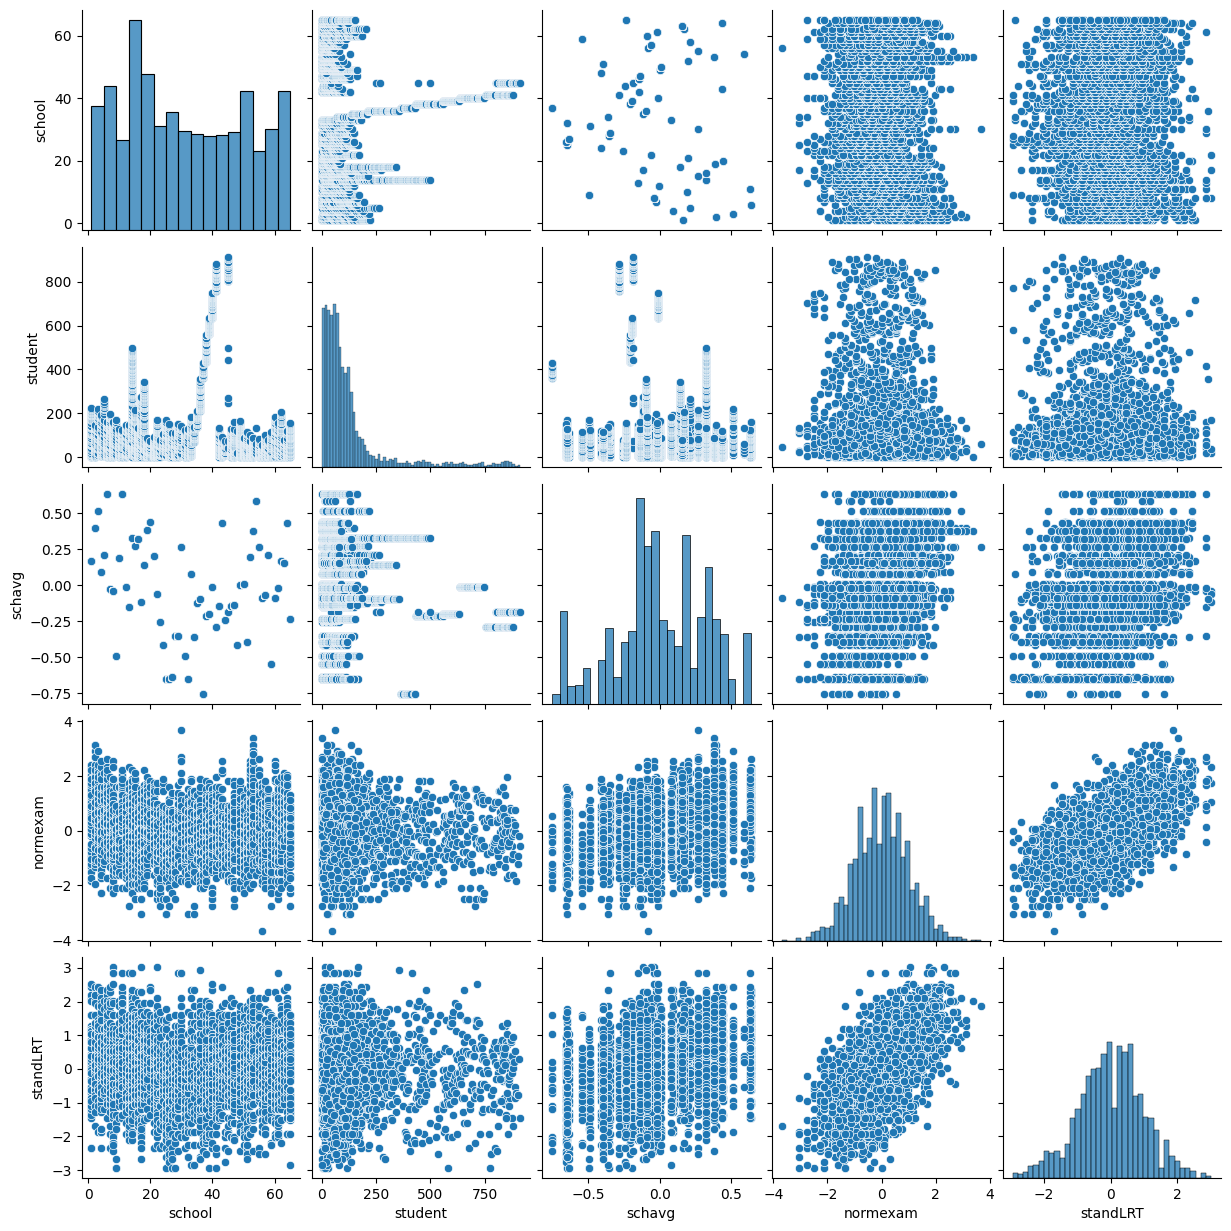

In [78]:
# Pairplot para comparação
sns.pairplot(final_data)

As distribuições permite-nos apontar questões como:
- A mais forte relação de apresenta entre os teste, sem que essa correlação possa ser percebida também na média geral dos colégios
- A distribuição nos exames se aproxima do modelo normal
- A dispersão das notas no exame standLRT é maior que no normexam

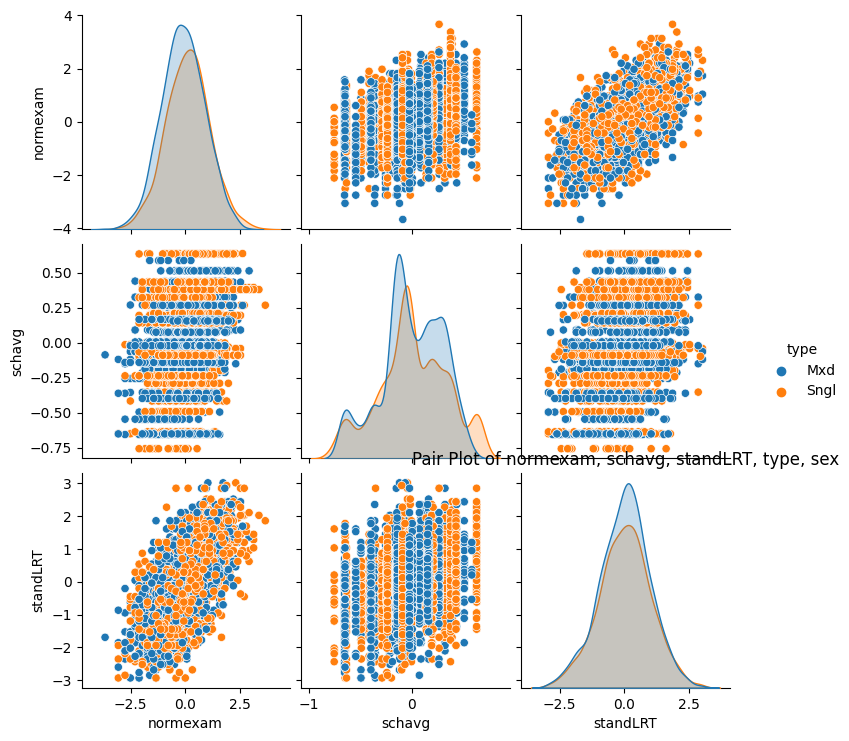

In [79]:
# Pairplot para visualização da diferença por tipo de escola
sns.pairplot(final_data[['normexam', 'schavg', 'standLRT', 'type', 'sex']], hue='type', diag_kind='kde')
plt.title('Pair Plot of normexam, schavg, standLRT, type, sex')
plt.show()

Apesar de não ocorrer com a média das escolas ("schavg"), nota-se a distribuição aproximadamente normal das notas no "standLRT" e no "normexam". O tipo de escola exclusiva ("Sngl") aparenta ter alguma vantagem nas notas mais elevada, sem que se sobressaia de fato da massa de notas do tipo de escola mista ("mxt"). Um maior detalhamento de faz necessário para compreender a situação em cada tipo de escola.

           count      mean       std       min       25%       50%       75%  \
type sex                                                                       
Mxd  F     963.0  0.017142  0.957041 -2.752660 -0.623051  0.004322  0.678759   
     M    1015.0 -0.199147  0.990614 -3.666072 -0.852670 -0.197611  0.478194   
Sngl F    1256.0  0.142715  0.986434 -3.059543 -0.492781  0.134067  0.747228   
     M     472.0  0.027676  1.063907 -2.752660 -0.718656  0.073536  0.765918   

               max  
type sex            
Mxd  F    2.924667  
     M    2.408692  
Sngl F    3.666091  
     M    2.532352  


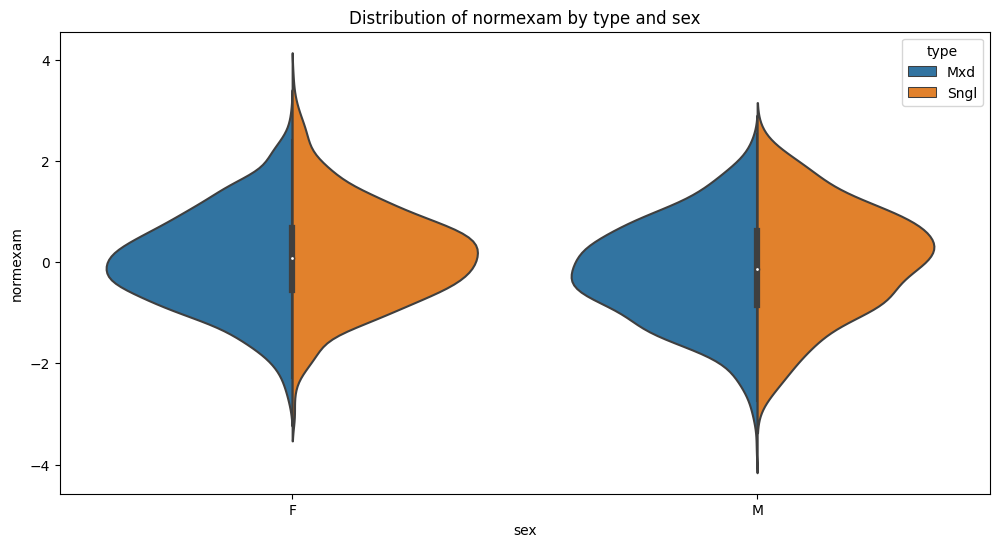

           count      mean       std       min       25%       50%       75%  \
type sex                                                                       
Mxd  F     963.0  0.017142  0.957041 -2.752660 -0.623051  0.004322  0.678759   
     M    1015.0 -0.199147  0.990614 -3.666072 -0.852670 -0.197611  0.478194   
Sngl F    1256.0  0.142715  0.986434 -3.059543 -0.492781  0.134067  0.747228   
     M     472.0  0.027676  1.063907 -2.752660 -0.718656  0.073536  0.765918   

               max      mode    median  
type sex                                
Mxd  F    2.924667 -0.338842  0.004322  
     M    2.408692  0.402669 -0.197611  
Sngl F    3.666091 -0.419801  0.134067  
     M    2.532352  0.328072  0.073536  


In [80]:
# Criando divisão também por gênero
grouped_type_sex = final_data.groupby(['type', 'sex'])['normexam']
summary_stats = grouped_type_sex.describe()
print(summary_stats)

# Visualizando distribuição por gênero e tipo de escola
plt.figure(figsize=(12, 6))
sns.violinplot(x='sex', y='normexam', hue='type', data=final_data, split=True)
plt.title('Distribution of normexam by type and sex')
plt.show()

# Agrupando por 'type' e 'sex' e calculando estatísticas descritivas
grouped_type_sex = final_data.groupby(['type', 'sex'])['normexam']

# CalcularCálculo de moda e mediana
mode_values = grouped_type_sex.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
median_values = grouped_type_sex.median()

# DataFrame para armazenar as estatísticas descritivas, incluindo moda e mediana
summary_stats = grouped_type_sex.describe()

# Adicionando coluna da moda ao DataFrame
summary_stats['mode'] = mode_values

# Adicionando coluna da mediana ao DataFrame
summary_stats['median'] = median_values

# Visualizando estatísticas descritivas
print(summary_stats)

Uma disparidade pode ser observada no lado masculino, particularmente visível no violin plot acima. Também a disparidade numérica quando posto em foco a representatividade dos gêneros nos colégios exclusivos pode ser destacada no gráfico de estatísticas descritivas acima.

In [84]:
# Separando os grupos
group_mxd_f = final_data[(final_data['type'] == 'Mxd') & (final_data['sex'] == 'F')]['normexam']
group_mxd_m = final_data[(final_data['type'] == 'Mxd') & (final_data['sex'] == 'M')]['normexam']
group_sngl_f = final_data[(final_data['type'] == 'Sngl') & (final_data['sex'] == 'F')]['normexam']
group_sngl_m = final_data[(final_data['type'] == 'Sngl') & (final_data['sex'] == 'M')]['normexam']

# Executando o teste t
t_stat, p_value = ttest_ind(group_mxd_f, group_mxd_m)
print(f'Test Statistic for Mxd: {t_stat}\nP-value for Mxd: {p_value}')

t_stat, p_value = ttest_ind(group_sngl_f, group_sngl_m)
print(f'Test Statistic for Sngl: {t_stat}\nP-value for Sngl: {p_value}')


Test Statistic for Mxd: 4.934261657079866
P-value for Mxd: 8.719147154412438e-07
Test Statistic for Sngl: 2.1135225652000993
P-value for Sngl: 0.03469921776539657


Como se observa enquanto resultado da testagem, há relevância estatística na diferença de notas de alunos e alunas em ambos os casos, com foco dessa diferenciação nos colégios do tipo exclusivo.

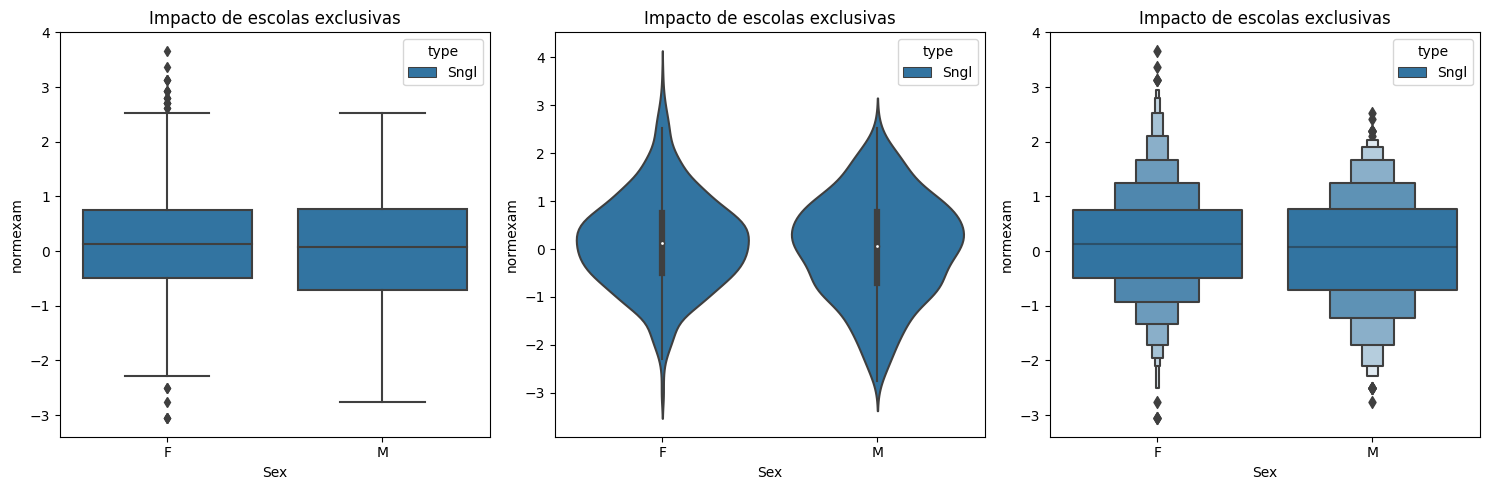

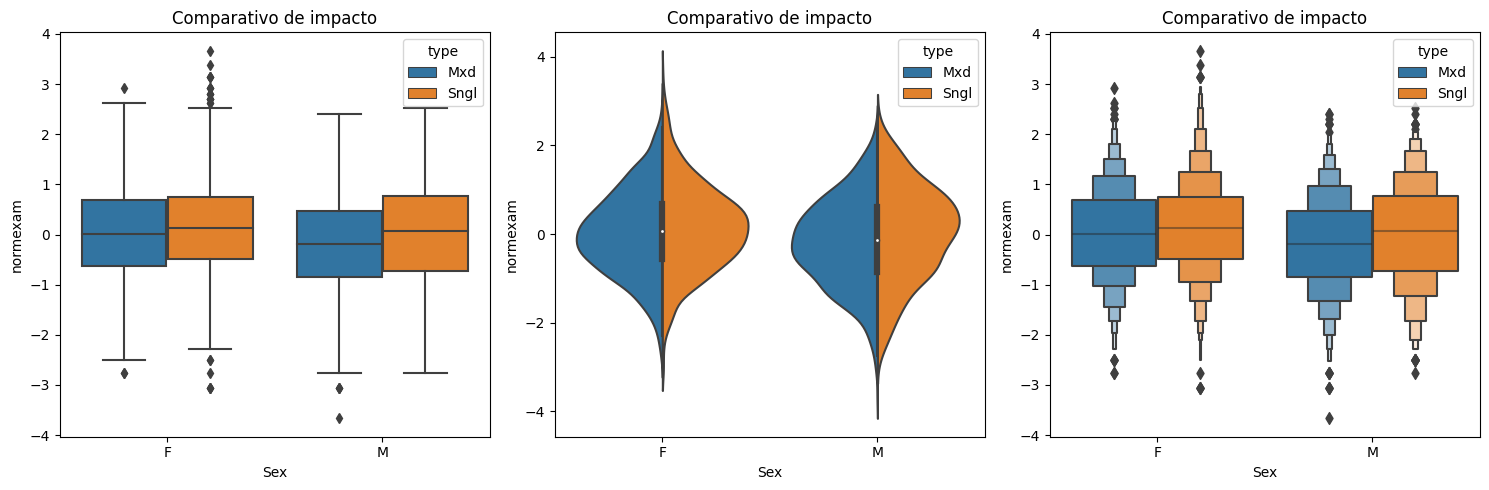

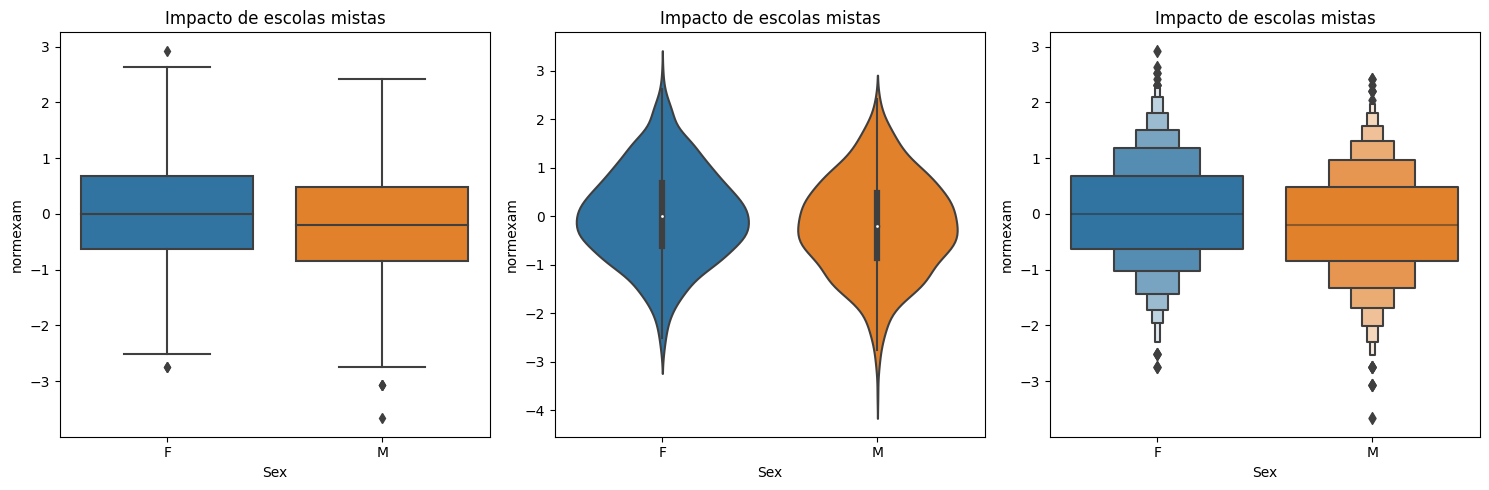

In [85]:
# Filtra o DataFrame para escolas do tipo "Sngl"
sngl_data = final_data[final_data['type'] == 'Sngl']

# Box Plots Facetados
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='sex', y='normexam', data=sngl_data, hue='type')
plt.title('Impacto de escolas exclusivas')
plt.xlabel('Sex')
plt.ylabel('normexam')

# Violin Plots Facetados
plt.subplot(1, 3, 2)
sns.violinplot(x='sex', y='normexam', data=sngl_data, hue='type')
plt.title('Impacto de escolas exclusivas')
plt.xlabel('Sex')
plt.ylabel('normexam')

# Boxen Plot
plt.subplot(1, 3, 3)
sns.boxenplot(x='sex', y='normexam', data=sngl_data, hue='type')
plt.title('Impacto de escolas exclusivas')
plt.xlabel('Sex')
plt.ylabel('normexam')

plt.tight_layout()
plt.show()

#===============================================================================

# Filtra o DataFrame para escolas dos tipos "Sngl" e "Mxd"
filtered_data = final_data[final_data['type'].isin(['Sngl', 'Mxd'])]

# Box Plots Facetados
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='sex', y='normexam', data=filtered_data, hue='type')
plt.title('Comparativo de impacto')
plt.xlabel('Sex')
plt.ylabel('normexam')

# Violin Plots Facetados
plt.subplot(1, 3, 2)
sns.violinplot(x='sex', y='normexam', data=filtered_data, hue='type', split=True)
plt.title('Comparativo de impacto')
plt.xlabel('Sex')
plt.ylabel('normexam')

# Boxen Plot
plt.subplot(1, 3, 3)
sns.boxenplot(x='sex', y='normexam', data=filtered_data, hue='type')
plt.title('Comparativo de impacto')
plt.xlabel('Sex')
plt.ylabel('normexam')

plt.tight_layout()
plt.show()

#===============================================================================

# Filtra o DataFrame para escolas do tipo "Mxd"
mxd_data = final_data[final_data['type'] == 'Mxd']

# Box Plots Facetados
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='sex', y='normexam', data=mxd_data)
plt.title('Impacto de escolas mistas')
plt.xlabel('Sex')
plt.ylabel('normexam')

# Violin Plots Facetados
plt.subplot(1, 3, 2)
sns.violinplot(x='sex', y='normexam', data=mxd_data, split=True)
plt.title('Impacto de escolas mistas')
plt.xlabel('Sex')
plt.ylabel('normexam')

# Boxen Plot
plt.subplot(1, 3, 3)
sns.boxenplot(x='sex', y='normexam', data=mxd_data)
plt.title('Impacto de escolas mistas')
plt.xlabel('Sex')
plt.ylabel('normexam')

plt.tight_layout()
plt.show()


A união dos gráficos acima permite uma análise comparativa e conclusões importantes para a sequência da análise. Destarte, a distorção apreciada no caso masculino entre diferentes dipos de escola é notóriamente mais intensa que no caso feminino.
Uma diferença também pode ser observada entre os gêneros em termos de distribuição, sem no entando que acompanhar uma diferença muito significativa quando isolamos as amostras do tipo exclusivo em particular.
Questões que devem ser a posteriori analisadas incluem o viés social que condiciona o colégio exclusivo, seja do gênero que for, mas também o fator que cria um abismo entre o número de garotos que desfrutam desse modelo de instituição frente ao número consideravelmente maior de garotas que o fazem. Compreende-se que esse viés social, cultural e, potencialmente, econômico, pode inferir maior distorção do que a que podemos agora auferir.

In [82]:
# Dividinto base em treino e teste

## Definindo features
X = final_data.drop(['normexam'], axis=1)
y = final_data['normexam']

## Divisão do dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Considerações Finais

Há indicativos claros bem como significância estatística para afirmarmos que uma boa nota no exame de interesse está atrelada ao gênero do aluno e ao tipo de escola em que se encontra o mesmo.

Naturalmente, essa questão carece de maior aprofundamento, na medida em que também são observadas disparidades relevantes entre os grupos, como: Diferença no número de escolas com exclusividade de gênero do lado dos estudantes do sexo feminino; Diferença no padrão de outliers principalmente se comparados os gêneros nos colégios mistos.  

Há então diferença?
- Existe diferença significativa entre gêneros, particularmente no que diz respeito a interferência do colégio de gênero exclusivo quando comparado ao desempenho dos mesmos grupos no colégio misto. Essa diferença surge particularmente expressiva no caso dos estudantes do séxo masculino, mas questões como a diferença numérica entre os grupos, característica de outliers e variância de certos grupos levantam perguntar que ainda necessitam de respostas para que se possa fazer maiores afirmações.